## ISRC Python Workshop 3: Topic Modeling (Apr. 06th 2017)

Text data is a great source for data analysis: sentiment analysis, topic retrieval, and so force. In this section, we will be covering a common precedure to conduct some basic analyses on text data retrieved from Scopus API. If you are interested in how to setup and get your own Twitter scraper work, please refer to the <a href="https://nbviewer.jupyter.org/github/zhiyzuo/uiowa-isrc-python/blob/master/2_web_scraping.ipynb">previous IPython Notebook</a> for more details on web data retrieval.

### 0. Retrieving Text Data

In [ ]:
## suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
with open("data/scopus_apikey.csv", "r") as f:
    key = f.read().strip()

In [ ]:
from pyscopus.scopus import Scopus
## Supply your own key here.
scopus = Scopus(key)

In [ ]:
## retrieve scopus ids and titles
results = scopus.search_venue(count = 5000, year_range=(2014,2016), \
                              sort_by='relevancy', show=False, \
                              venue_title='Journal of Machine Learning Research')

In [ ]:
abstracts = []
for item in results:
    abstracts.append(scopus.retrieve_abstract(scopus_id=item))

### Text Mining

Specifically, we will apply three classic clustering algorithms on the corpus and mine the underlying topical structures:

(i) <a href="https://www.datascience.com/blog/introduction-to-k-means-clustering-algorithm-learn-data-science-tutorials" target="_blank">K-means</a>

(ii) Latent Semantic Analysis (LSA) [1]

(iii) <span style="color:red">Latent Dirichlet Allocation (LDA)</span> [2]

We will not cover WHAT these algorithms are, but it is good to understand the basics of the assumptions and the mechanisms.

###### In this workshop, we will use implementations of LDA mentioned above from package <a href="http://scikit-learn.org/stable/" target="_blank">scikit-learn</a>

### 1. Preprocessing Text Data (Data Cleaning)

Before we do anything with the fancy algorithms, we must keep in mind that the most important step is to clean the data. Real-world data has many noises in it. We may get results that do not make any sense without proper preprocessing.

In [2]:
import numpy as np

In [3]:
## Let's look at the data first
with open('data/corpus.csv', 'r') as f:
    corpus = [text.replace('\r', '').replace('"','') \
              for text in f.read().split('\n')\
              if len(text) > 0]

In [4]:
## Show 3 abstracts
for doc in corpus[:3]:
    print(doc)
    print('--------------')

Many real-world applications require varying costs for different types of mis-classification errors. Such a cost-sensitive classification setup can be very different from the regular classification one, especially in the multiclass case. Thus, traditional meta-algorithms for regular multiclass classification, such as the popular one-versus-one approach, may not always work well under the cost-sensitive classification setup. In this paper, we extend the one-versus-one approach to the field of cost-sensitive classification. The extension is derived using a rigorous mathematical tool called the cost-transformation technique, and takes the original one-versus-one as a special case. Experimental results demonstrate that the proposed approach can achieve better performance in many cost-sensitive classification scenarios when compared with the original one-versus-one as well as existing cost-sensitive classification algorithms. Reduction from cost-sensitive multiclass classification to one-ve

#### Bag of words
We do not really care the order of the words. We consider each document a <a href="https://en.wikipedia.org/wiki/Bag-of-words_model" target="_blank">bag of words</a>.

In [7]:
## scikit-learn provides convenient functions to preprocess data
from sklearn.feature_extraction.text import CountVectorizer
## remove stop words, which are some common words like I, you, and we.
counter = CountVectorizer(max_df=0.95, min_df=2, \
                                stop_words='english')
corpus_counter = counter.fit_transform(corpus)
counter.get_feature_names()[:15]

[u'2008',
 u'2011',
 u'2013',
 u'97',
 u'able',
 u'access',
 u'account',
 u'accuracy',
 u'accurate',
 u'achieve',
 u'achieves',
 u'active',
 u'actually',
 u'acyclic',
 u'adapt']

However, this seems not reasonable: (i) we probably do not want numbers; (ii) words in different forms are redundant (`achieve` and `achieves` are basically the same thing).

In [8]:
## first remove numbers
from string import digits
corpus_nodigits = [doc.translate(None, digits) for doc in corpus]

Let's try the `CountVectorizer` again.

In [9]:
## stemming: get the `stem` of the words
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
corpus_for_stem = [doc.split() for doc in corpus_nodigits]
corpus_stemmed_nodigits = [' '.join([stemmer.stem(word) for word in doc])\
                            for doc in corpus_for_stem]

In [10]:
counter = CountVectorizer(max_df=0.95, min_df=2, \
                                stop_words='english')
## corpus_counter is a doc-term sparse matrix
corpus_counter = counter.fit_transform(corpus_stemmed_nodigits)
print(corpus_counter.shape)
words = np.asarray(counter.get_feature_names())
print(words.shape)

(80, 789)
(789,)


### 2. Some summary statistics (Know your data)

In [12]:
## Top 5 words of each document and their frequencies
## NOTE: toarray is not recommended. This is just for illustration purpose.
top_word_indices = np.argsort(-corpus_counter.toarray())[:, :5]
top_words = [words[top_word_indices[index,:]] \
             for index in range(top_word_indices.shape[0])]
top_word_frequency = [corpus_counter[index, top_word_indices[index]].toarray() \
             for index in range(top_word_indices.shape[0])]
print(top_words[:3])
print(top_word_frequency[:3])

[array([u'cost', u'classif', u'sensit', u'approach', u'multiclass'], 
      dtype='<U14'), array([u'variat', u'model', u'infer', u'method', u'box'], 
      dtype='<U14'), array([u'variat', u'bayesian', u'model', u'construct', u'support'], 
      dtype='<U14')]
[array([[8, 8, 6, 3, 3]]), array([[7, 6, 5, 5, 4]]), array([[5, 4, 2, 2, 2]])]


#### Word Cloud
See https://github.com/amueller/word_cloud.

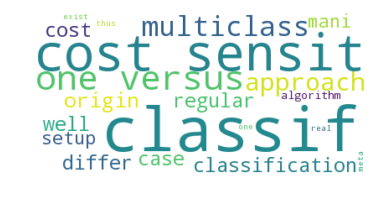

In [13]:
from wordcloud import WordCloud
## plot the first document
wordcloud = WordCloud(background_color="white", max_words=20)
wordcloud.generate(corpus_stemmed_nodigits[0])
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 3. Run LDA

In [14]:
from sklearn.decomposition import LatentDirichletAllocation
## large n will produce fine-grained topics
## small n will produce coarse-grained topics
lda = LatentDirichletAllocation(n_topics=5)
corpus_lda = lda.fit_transform(corpus_counter)

/Users/zhiyzuo/.virtualenvs/PyEnv/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [15]:
def print_top_words(model, feature_names, n_top_words):
    top_word_list = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        top_words = [feature_names[i] \
                     for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(" ".join(top_words))
        top_word_list.append(top_words)
        
    return top_word_list

In [16]:
top_word_list = print_top_words(lda, words, 10)

Topic #0:
thi class learn problem use method algorithm distribut model data
Topic #1:
method thi propos data markov time use matrix ensembl infer
Topic #2:
algorithm data learn cluster use model function thi propos method
Topic #3:
model variat infer algorithm support inform thi bayesian gradient classif
Topic #4:
data learn problem thi estim use model kernel function set


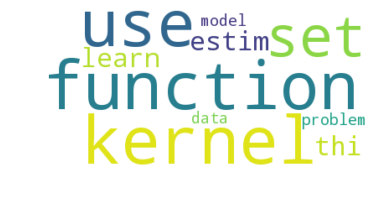

In [17]:
lda_wordcloud = WordCloud(background_color="white", max_words=10, relative_scaling=0)
lda_wordcloud.generate(' '.join(top_word_list[4]))
import matplotlib.pyplot as plt
plt.imshow(lda_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 4. Conclusion

Of course there are a lot of things to do. We can, for example, compare the document similarity across the latent topic space. To interprete the meaning of the topics corresponding to the top keywords, we may need to rerun LDA with different number of topics. This tutorial provides a simple procedure on how we can conduct text analyses in Python (in this case, dimensionality reduction by mapping document and words onto a lower-dimemnsion topic space).

Finally, let's try to use a fantastic tool `pyLDAVis`. See <a href="http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb" target="_blank">here</a> for a more detailed example. 

In [18]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-04-02 12:50:11.318358. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [19]:
pyLDAvis.sklearn.prepare(lda, corpus_counter, counter)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      32.025405        1       1 -0.034156 -0.015323
4      24.529650        1       2 -0.046829  0.059117
2      21.484758        1       3 -0.012369 -0.010762
1      11.131358        1       4  0.005532 -0.060917
3      10.828829        1       5  0.087822  0.027885, topic_info=     Category       Freq        Term      Total  loglift  logprob
term                                                             
765   Default  12.000000      variat  12.000000  30.0000  30.0000
23    Default  70.000000   algorithm  70.000000  29.0000  29.0000
343   Default  22.000000       infer  22.000000  28.0000  28.0000
101   Default  39.000000       class  39.000000  27.0000  27.0000
704   Default  19.000000     support  19.000000  26.0000  26.0000
366   Default  17.000000      kernel  17.000000  25.0000  25.0000
111   Default  28.000000     cluster  28.000000  24.0000  24.0000
345   Default  16.000000      inform  16.000000  23.0000  23.0000
303   Default   8.000000    gradient   8.000000  22.0000  22.0000
64    Default  21.000000    bayesian  21.000000  21.0000  21.0000
421   Default  56.000000      method  56.000000  20.0000  20.0000
440   Default  65.000000       model  65.000000  19.0000  19.0000
410   Default  21.000000      markov  21.000000  18.0000  18.0000
160   Default   9.000000        cost   9.000000  17.0000  17.0000
104   Default  20.000000     classif  20.000000  16.0000  16.0000
170   Default  83.000000        data  83.000000  15.0000  15.0000
768   Default  17.000000      vector  17.000000  14.0000  14.0000
637   Default  11.000000      select  11.000000  13.0000  13.0000
131   Default  17.000000     complex  17.000000  12.0000  12.0000
232   Default   6.000000     ensembl   6.000000  11.0000  11.0000
270   Default  19.000000      featur  19.000000  10.0000  10.0000
639   Default   8.000000      sensit   8.000000   9.0000   9.0000
264   Default  12.000000      factor  12.000000   8.0000   8.0000
419   Default  14.000000      measur  14.000000   7.0000   7.0000
566   Default   9.000000        rate   9.000000   6.0000   6.0000
161   Default   8.000000       count   8.000000   5.0000   5.0000
690   Default   6.000000      stream   6.000000   4.0000   4.0000
729   Default  18.000000        time  18.000000   3.0000   3.0000
165   Default   6.000000   criterion   6.000000   2.0000   2.0000
463   Default  24.000000         new  24.000000   1.0000   1.0000
...       ...        ...         ...        ...      ...      ...
344    Topic5   1.583090   inference   3.769590   1.3554  -6.0331
667    Topic5   2.206973      sketch   5.266623   1.3532  -5.7008
566    Topic5   4.149649        rate   9.918252   1.3516  -5.0694
630    Topic5   1.557486     scalabl   3.735899   1.3480  -6.0494
345    Topic5   6.749766      inform  16.243756   1.3448  -4.5829
528    Topic5   1.575204  prediction   3.795651   1.3435  -6.0380
677    Topic5   1.564822     special   3.783060   1.3402  -6.0447
756    Topic5   2.867592        user   7.436026   1.2701  -5.4390
343    Topic5   8.169322       infer  22.162633   1.2249  -4.3920
603    Topic5   2.213055     respect   6.101646   1.2088  -5.6981
742    Topic5   1.592005        tune   4.631187   1.1551  -6.0274
342    Topic5   1.522930       induc   4.494713   1.1407  -6.0718
264    Topic5   4.208599      factor  12.970241   1.0974  -5.0553
131    Topic5   5.353491     complex  17.667012   1.0290  -4.8147
64     Topic5   6.199679    bayesian  21.403615   0.9839  -4.6679
768    Topic5   4.952038      vector  17.111147   0.9830  -4.8926
104    Topic5   5.556912     classif  20.010999   0.9417  -4.7774
179    Topic5   4.068074    demonstr  14.444771   0.9558  -5.0893
184    Topic5   3.444591       deriv  11.519417   1.0157  -5.2556
440    Topic5  11.178142       model  65.132165   0.4605  -4.0785
270    Topic5   4.837121      featur  19.314362   0.8384  -4.9161
567    Topic5  

/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-04-02 12:50:11.749770. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Reference:

[1] Deerwester, S., Dumais, S. T., Furnas, G. W., Landauer, T. K., & Harshman, R. (1990). Indexing by latent semantic analysis. Journal of the American society for information science, 41(6), 391.

[2] Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.